In [281]:
%reload_ext autoreload
%autoreload 2

# Analysis 101

To do:
- colour-code points by the distance from the mean pH to contextualise the magnitude of experimental change in pH
- amalgamate any studies with n=1 since need sd for hedges
- deal with temperature-only studies (not all studies have carbonate chemistry)
- plot 3d plot of temperature, ph,


In [414]:
### import
# general
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# clustering
from sklearn.cluster import KMeans

# custom
import analysis, utils

In [283]:
climatology_df[climatology_df.index == "10.1111/jpy.13290"]

,data_ID,doi,location,mean_pH_30y_ensemble,models_with_data_n,mean_pH_30y_ensemble_se,MMM_30y_mean,geometry
10.1111/jpy.13290,1,"Lizard Island, GBR, Australia",8.086768,10,0.004111,29.046213,c(145.459236111111,-14.6922777777778)


In [284]:
### for one study, calculate the hedges g
i = 0   # index of test study
climatology_data_fp = "data/climatology/site_locations_with_MMM_and_pH.csv"
climatology_df = pd.read_csv(climatology_data_fp, index_col=2)
# drop the first column
climatology_df = climatology_df.drop(columns=climatology_df.columns[0])

## Multi-variable study

In [285]:
test_doi = climatology_df[climatology_df.index == "10.1111/jpy.13290"]
carb_df = pd.read_pickle("data/temp_carb_df.pkl")
test_df = carb_df.loc[carb_df["doi"] == test_doi.index[0]]
test_df.head()

,authors,calcification,calcification_sd,calcification_se,calcification_units,cleaned_coords,co3,co3_sd,co3_se,coords,...,secondary_check,species_types,t_in,t_in_sd,t_in_se,ta,ta_sd,ta_se,taxa,year
0,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,1.970803,0.571428,0.25555,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,210.0,NaN,2.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Porollithon cf onkodes,27.1,NaN,0.06,2292.0,NaN,1.0,Algae,2023-01-01
1,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,2.408759,0.424316,0.18976,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,214.0,NaN,1.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Porollithon cf onkodes,29.4,NaN,0.08,2291.0,NaN,1.0,Algae,2023-01-01
2,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,1.664234,0.375356,0.167864,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,117.0,NaN,1.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Porollithon cf onkodes,27.2,NaN,0.06,2292.0,NaN,1.0,Algae,2023-01-01
3,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,1.839416,0.277437,0.124074,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,125.0,NaN,1.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Porollithon cf onkodes,29.5,NaN,0.08,2291.0,NaN,1.0,Algae,2023-01-01
4,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,1.467626,0.293757,0.131372,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,210.0,NaN,2.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Lithophyllum cf insipidum,27.1,NaN,0.06,2292.0,NaN,1.0,Algae,2023-01-01


In [286]:
# assign species_types values to unique ints
species_types = test_df["species_types"].unique()
species_types_dict = {species_type: i for i, species_type in enumerate(species_types)}
test_df.loc[:,"species_types"] = test_df["species_types"].map(species_types_dict)

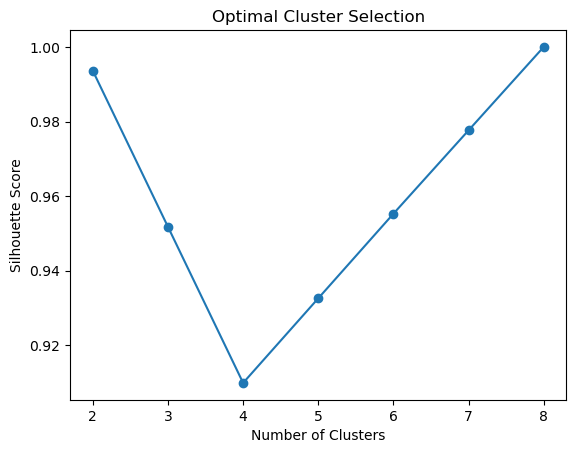

In [287]:
# subset = test_df[test_df["species_types"] == "Porollithon cf onkodes"]
subset = test_df
# Select relevant columns
treatment_data = subset[['t_in', 'phtot', 'irr']].dropna()

# Find optimal number of clusters
optimal_k, score_list = utils.optimal_kmeans(treatment_data)

# Fit KMeans with the best number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
subset.loc[:,'treatment_group'] = kmeans.fit_predict(treatment_data)

# Split dataframe into separate treatments
treatment_groups = {name: group for name, group in subset.groupby('treatment_group')}

# Optional: Plot Silhouette Scores
plt.plot(*zip(*score_list), marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Cluster Selection')
plt.show()

In [288]:
for tg in treatment_groups.values():
    print("TREATMENT GROUP {}".format(tg['treatment_group'].iloc[0]))
    print(tg.loc[:,['t_in', 'phtot', 'irr', 'species_types']])

TREATMENT GROUP 0
   t_in  phtot    irr species_types
1  29.4   7.98  250.0             0
5  29.4   7.98  250.0             1
TREATMENT GROUP 1
    t_in  phtot   irr species_types
9   29.4   7.98  30.0             2
13  29.4   7.98  30.0             3
TREATMENT GROUP 2
   t_in  phtot    irr species_types
2  27.2  7.698  250.0             0
6  27.2  7.698  250.0             1
TREATMENT GROUP 3
    t_in  phtot   irr species_types
8   27.1  8.003  30.0             2
12  27.1  8.003  30.0             3
TREATMENT GROUP 4
   t_in  phtot    irr species_types
0  27.1  8.003  250.0             0
4  27.1  8.003  250.0             1
TREATMENT GROUP 5
    t_in  phtot   irr species_types
10  27.2  7.698  30.0             2
14  27.2  7.698  30.0             3
TREATMENT GROUP 6
   t_in  phtot    irr species_types
3  29.5  7.694  250.0             0
7  29.5  7.694  250.0             1
TREATMENT GROUP 7
    t_in  phtot   irr species_types
11  29.5  7.694  30.0             2
15  29.5  7.694  30.0       

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_48218/45990617.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mono_var_subset.loc[:, 'calcification_sd'] = mono_var_subset[['calcification_se', 'n']].apply(lambda row: analysis.calc_sd_from_se(row['calcification_se'], row['n']), axis=1)


Text(0, 0.5, "Hedge's g")

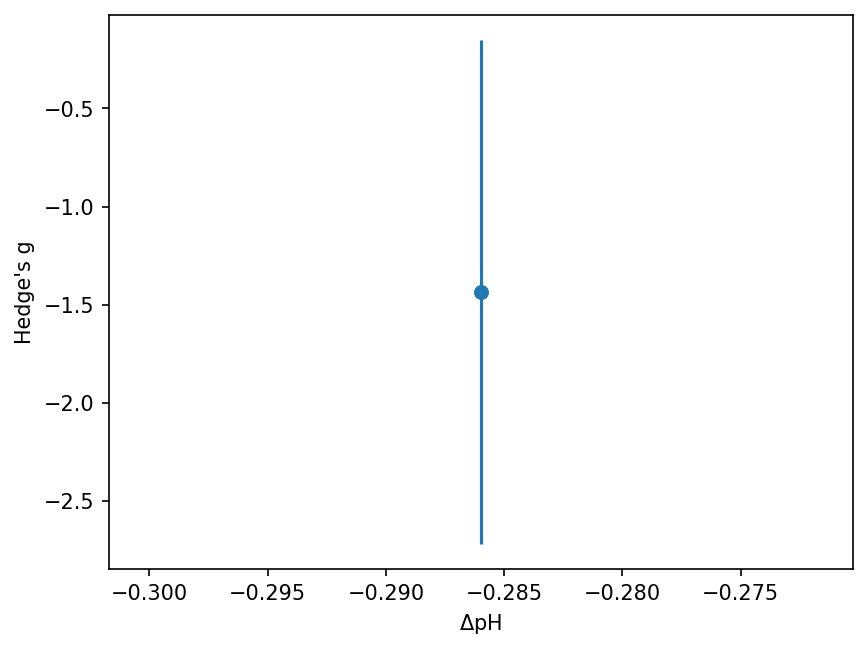

In [160]:
### artificially reducing to single group (same species, constant T and irradiance, changing pH)
# mono_var_subset = pd.concat(treatment_groups)
mono_var_subset = treatment_groups[0]

cols = ['t_in', 'phtot', 'irr', 'calcification', 'calcification_se', 'n']
mono_var_subset = mono_var_subset[cols]
mono_var_subset.loc[:, 'calcification_sd'] = mono_var_subset[['calcification_se', 'n']].apply(lambda row: analysis.calc_sd_from_se(row['calcification_se'], row['n']), axis=1)
mono_var_subset


t1 = mono_var_subset.iloc[0]
t2 = mono_var_subset.iloc[1]

# TODO: colour-code by the distance from the mean pH to contextualise the magnitude of experimental change in pH

hg, (hg_ci_l, hg_ci_u) = analysis.calc_hedges_g(t2["calcification"], t1["calcification"], t2["calcification_sd"], t1["calcification_sd"], t2["n"], t1["n"])
delta_ph = t2["phtot"] - t1["phtot"]

fig, ax = plt.subplots(1, 1, dpi=150)
plt.scatter(delta_ph, hg)
plt.errorbar(delta_ph, hg, yerr=[[hg-hg_ci_l], [hg_ci_u-hg]], fmt='o')
# formatting
plt.xlabel("$\\Delta$pH")
plt.ylabel("Hedge's g")

# GPT to scale


In [444]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use your existing function to determine optimal clusters
def optimal_kmeans(data, max_clusters=8):
    best_k = 2  # Minimum sensible number of clusters
    best_score = -1
    scores = []

    for k in range(2, min(len(data), max_clusters + 1)):  # Avoid excessive clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=max_clusters)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        scores.append((k, score))

        if score > best_score:
            best_score = score
            best_k = k

    return best_k, scores


def cluster_treatments(df, vars_to_cluster):
    """Cluster treatments based on independent variables and species types."""
    
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.cluster._kmeans')  # Suppress convergence warnings

    df = df.copy()  # Avoid modifying the original dataframe

    # Ensure 'treatment_group' column exists
    df['treatment_group'] = np.nan

    # Cluster separately for each species type
    for species, group_df in df.groupby('species_types'):
        treatment_data = group_df[vars_to_cluster].dropna(axis=1)  # Only keep non-missing variables

        if treatment_data.shape[0] < 2:  # Skip clustering if there's only one sample
            print(f"Skipping {species}: Not enough samples for clustering")
            continue

        try:
            optimal_k, _ = optimal_kmeans(treatment_data)  # Determine optimal clusters
            kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
            df.loc[group_df.index, 'treatment_group'] = kmeans.fit_predict(treatment_data)
        except ValueError:
            print(f"Error: Could not cluster {species}")
            df.loc[group_df.index, 'treatment_group'] = np.nan

    return df


def determine_control_conditions(df):
    """Identify the rows corresponding to min temperature and/or max pH."""
    grouped = df.groupby('treatment_group')

    control_treatments = {}

    for group, sub_df in grouped:
        group = int(group)  # convert group to integer for consistency
        min_temp = sub_df.loc[sub_df['t_in'].idxmin()]['t_in'] if not any(sub_df['phtot'].isna()) else None # Row with minimum temperature
        max_pH = sub_df.loc[sub_df['phtot'].idxmax()]['phtot'] if not any(sub_df['phtot'].isna()) else None # Row with maximum pH

        control_treatments[group] = {
            'control_t_in': min_temp,
            'control_phtot': max_pH,
        }

    return control_treatments

from itertools import combinations


def compute_hedges_g(df, vars_to_compare=['t_in', 'phtot']):
    """
    Compute Hedges' g effect size for each treatment compared to the control within each species.

    Args:
        df (pd.DataFrame): DataFrame containing treatment groups.
        vars_to_compare (list): List of numeric variables to compute Hedges' g for.

    Returns:
        pd.DataFrame: DataFrame containing effect sizes for each treatment group.
    """
    results = []

    for species, group_df in study_df.groupby('species_types'):
        treatment_groups = group_df['treatment_group'].unique()
        
        # Compare each pair of treatment groups
        for group1, group2 in combinations(treatment_groups, 2):
            df1 = group_df[group_df['treatment_group'] == group1]
            df2 = group_df[group_df['treatment_group'] == group2]
            
            if df1.n.all() == 1 and df2.n.all() == 1:
                # aggregate data (take mean calcification and sd)
                df1['calcification_sd'] = np.std(df1['calcification'])
                df2['calcification_sd'] = np.std(df2['calcification'])
                n1, n2 = len(df1), len(df2)
                
                df1 = utils.aggregate_df(df1)
                df2 = utils.aggregate_df(df2)
                df1['n'] = n1
                df2['n'] = n2

            if len(df1) != len(df2):
                print(f"Skipping comparison between {group1} and {group2} treatments: Different sample sizes")
                continue
            
            if isinstance(df1, pd.DataFrame):   # if there are multiple samples
                for sample in range(len(df1)):
                    df1_sample = df1.iloc[sample]
                    df2_sample = df2.iloc[sample]
                    
                    for var in vars_to_compare:

                        other_var = 't_in' if var == 'phtot' else 'phtot'  # The variable that must remain constant
                        
                        # Check if the other variable is approximately the same in both groups
                        if np.isclose(df1_sample[other_var], df2_sample[other_var], atol=0.05):  # Adjust tolerance as needed
                            if var == 'phtot':
                                # mu1 is greater than mu2, switch groups such that control = mu1
                                if df1_sample[var] < df2_sample[var]:
                                    group1, group2 = group2, group1
                                    df1_sample, df2_sample = df2_sample, df1_sample
                                delta_var = df2_sample[var] - df1_sample[var]
                            elif var == 't_in':
                                # mu1 is less than mu2, switch groups such that control = mu1
                                if df1_sample[var] > df2_sample[var]:
                                    group1, group2 = group2, group1
                                    df1_sample, df2_sample = df2_sample, df1_sample
                                delta_var = df1_sample[var] - df2_sample[var]
                                    
                            mu1, std1, n1 = df1_sample['calcification'], df1_sample['calcification_sd'], df1_sample['n']
                            mu2, std2, n2 = df2_sample['calcification'], df2_sample['calcification_sd'], df2_sample['n']

                            g = analysis.calc_hedges_g(mu2, mu1, std2, std1, n2, n1)    # TODO: check signage
                            results.append({
                                'doi': study_df.doi.iloc[0],
                                'species_types': species,
                                'group1': group1,
                                'group2': group2,
                                'variable': var,
                                'delta_var': delta_var,
                                'hedges_g': g[0],
                                'hg_ci_l': g[1][0],
                                'hg_ci_u': g[1][1],
                                })
            else:
                df1_sample = df1
                df2_sample = df2
                for var in vars_to_compare:
                    
                    other_var = 't_in' if var == 'phtot' else 'phtot'  # The variable that must remain constant
                    
                    # Check if the other variable is approximately the same in both groups
                    if np.isclose(df1_sample[other_var], df2_sample[other_var], atol=0.05):  # Adjust tolerance as needed
                        if var == 'phtot':
                            # mu1 is greater than mu2, switch groups such that control = mu1
                            if df1_sample[var] < df2_sample[var]:
                                group1, group2 = group2, group1
                                df1_sample, df2_sample = df2_sample, df1_sample
                            delta_var = df2_sample[var] - df1_sample[var]
                        elif var == 't_in':
                            # mu1 is less than mu2, switch groups such that control = mu1
                            if df1_sample[var] > df2_sample[var]:
                                group1, group2 = group2, group1
                                df1_sample, df2_sample = df2_sample, df1_sample
                            delta_var = df2_sample[var] - df1_sample[var]
                                
                        mu1, std1, n1 = df1_sample['calcification'], df1_sample['calcification_sd'], df1_sample['n']
                        mu2, std2, n2 = df2_sample['calcification'], df2_sample['calcification_sd'], df2_sample['n']

                        g = analysis.calc_hedges_g(mu2, mu1, std2, std1, n2, n1)    # TODO: check signage
                        results.append({
                            'doi': study_df.doi.iloc[0],
                            'species_types': species,
                            'group1': group1,
                            'group2': group2,
                            'variable': var,
                            'delta_var': delta_var,
                            'hedges_g': g[0],
                            'hg_ci_l': g[1][0],
                            'hg_ci_u': g[1][1],
                        })
    return results


all_results = []
failures = []
for study_name, study_df in carb_df.groupby('doi'):
    print(f"Processing study: {study_name}")
    
    if len(study_df) < 2:
        print(f"Skipping study {study_name} due to insufficient data for hedges g calculation.")
        continue
    
    # 1. assign treatment groups to each row
    study_df = cluster_treatments(study_df, independent_vars)
    if any(study_df['treatment_group'].isna()):
        failures.append(study_name)
        continue
    # 2. identify control conditions (min_temp, max_pH)
    control_conditions = determine_control_conditions(study_df)

    # 3. compute Hedges' g for each treatment group
    hedges_results = compute_hedges_g(study_df)
    all_results.extend(hedges_results)

print(f"\nFailed to cluster {len(failures)} studies: {failures}")

results_df = pd.DataFrame(all_results)
results_df.head()

Processing study: 10.1007/s00227-016-2986-8
Processing study: 10.1007/s00227-022-04071-6
Processing study: 10.1007/s00338-012-0952-6
Processing study: 10.1007/s00338-019-01775-y
Processing study: 10.1007/s00338-020-01995-7
Error: Could not cluster Monstastraea cavernosa
Processing study: 10.1007/s13131-022-2037-x
Processing study: 10.1016/j.chemgeo.2018.09.004
Processing study: 10.1016/j.ecochg.2021.100016
Processing study: 10.1016/j.jembe.2016.10.002
Processing study: 10.1016/j.jembe.2019.151225
Processing study: 10.1016/j.marenvres.2023.106150
Processing study: 10.1029/2020JG005726
Error: Could not cluster Operculina ammonoides
Processing study: 10.1038/s41598-019-40620-8
Processing study: 10.1038/s41598-022-06896-z
Processing study: 10.1038/s42003-022-04353-1
Processing study: 10.1088/1755-1315/253/1/012022
Processing study: 10.1093/icesjms/fsaa015
Processing study: 10.1098/rsos.170683
Processing study: 10.1098/rsos.220760
Processing study: 10.1098/rspb.2019.0614
Processing study: 1

,doi,species_types,group1,group2,variable,delta_var,hedges_g,hg_ci_l,hg_ci_u
0,10.1007/s00227-016-2986-8,Acropora pulchra,2.0,1.0,phtot,-0.330000,-2.238796,-3.868438,-0.609153
1,10.1007/s00227-016-2986-8,Acropora pulchra,3.0,2.0,t_in,2.750000,-0.430611,-1.711220,0.849997
2,10.1007/s00227-016-2986-8,Acropora pulchra,0.0,1.0,t_in,2.800000,-1.056397,-2.367992,0.255199
3,10.1007/s13131-022-2037-x,Halimeda opuntia,1.0,2.0,phtot,-0.215376,0.904121,-0.379184,2.187426
4,10.1007/s13131-022-2037-x,Halimeda opuntia,0.0,2.0,t_in,0.100000,-1.612635,-3.194758,-0.030512


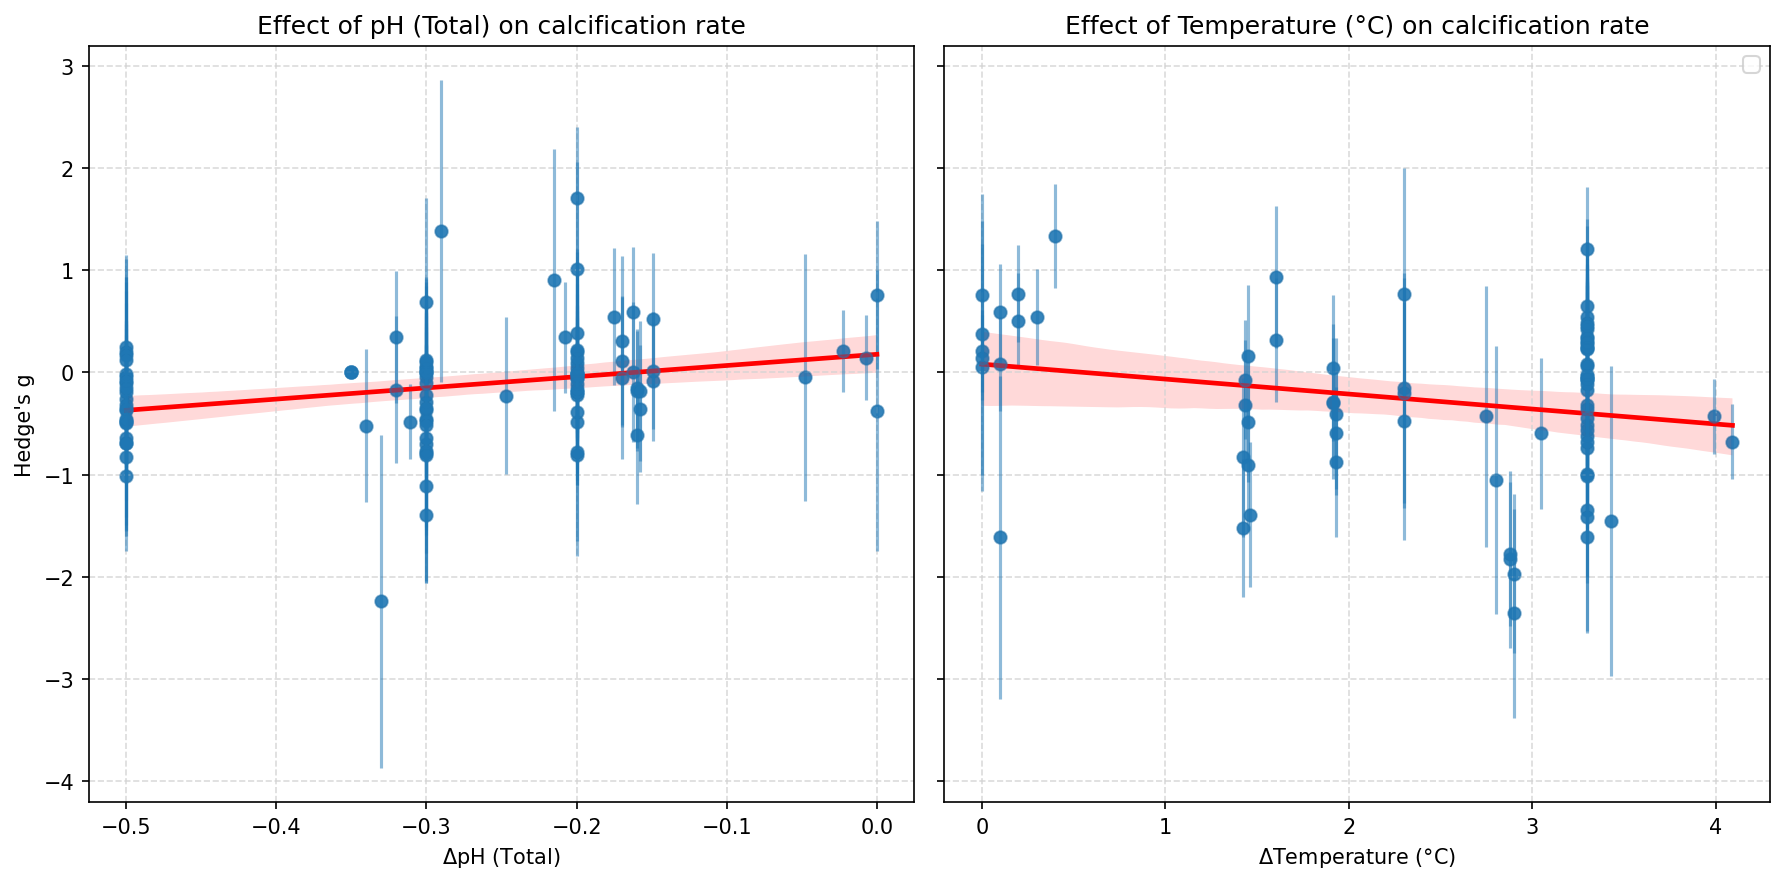

In [450]:
fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    # plot delta_var vs hedges g
    subset = results_df[results_df['variable'] == var]
    
    ax.scatter(subset['delta_var'], subset['hedges_g'], alpha=0.8, lw=0.1, edgecolor='black')
    # TODO: plot error bars (from hg_ci_l and hg_ci_u)
    ax.errorbar(subset['delta_var'], subset['hedges_g'], yerr=[subset['hedges_g'] - subset['hg_ci_l'], subset['hg_ci_u'] - subset['hedges_g']], fmt='o',
                alpha=0.5)
    sns.regplot(ax=ax, x='delta_var', y='hedges_g', data=subset, ci=95, scatter=False, line_kws={"color": "red"})

    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    
# format legend to show regression line, shaded region as 95% CI
labels = ['first order regression', '95% CI']
ax_t.legend(labels)

ax_ph.set_ylabel("Hedge's g")
ax_t.legend()

plt.tight_layout()


In [406]:
subset['delta_var']

1     -2.75
2     -2.80
4     -0.10
5     -0.20
6     -0.30
       ... 
179   -2.30
180   -2.30
181    0.00
185    0.00
187   -3.43
Name: delta_var, Length: 77, dtype: float64

In [ ]:
subset['delta_var']

In [352]:
study_df = carb_df.loc[carb_df["doi"] == "10.1038/s41598-022-06896-z"]
# 1. assign treatment groups to each row
study_df = cluster_treatments(study_df, independent_vars)

# 2. identify control conditions (min_temp, max_pH)
control_conditions = determine_control_conditions(study_df)

# # 3. compute Hedges' g for each treatment group
hedges_results = compute_hedges_g(study_df)
# all_results.append(hedges_results)

Skipping comparison between 2.0 and 0.0 treatments: Different sample sizes
Skipping comparison between 2.0 and 3.0 treatments: Different sample sizes
Skipping comparison between 2.0 and 1.0 treatments: Different sample sizes
Skipping comparison between 0.0 and 3.0 treatments: Different sample sizes
Skipping comparison between 0.0 and 1.0 treatments: Different sample sizes
Skipping comparison between 3.0 and 1.0 treatments: Different sample sizes
Skipping comparison between 2.0 and 0.0 treatments: Different sample sizes
Skipping comparison between 2.0 and 1.0 treatments: Different sample sizes
Skipping comparison between 2.0 and 3.0 treatments: Different sample sizes
Skipping comparison between 0.0 and 1.0 treatments: Different sample sizes
Skipping comparison between 0.0 and 3.0 treatments: Different sample sizes
Skipping comparison between 1.0 and 3.0 treatments: Different sample sizes
Skipping comparison between 0.0 and 1.0 treatments: Different sample sizes
Skipping comparison betwe

In [309]:
sel_cols = ['species_types', 'treatment_group', 'phtot', 't_in', 'irr', 'calcification', 'calcification_sd', 'n']
study_df[sel_cols]

,species_types,treatment_group,phtot,t_in,irr,calcification,calcification_sd,n
0,Porollithon cf onkodes,1.0,8.003,27.1,250.0,1.970803,0.571428,5.0
1,Porollithon cf onkodes,0.0,7.980,29.4,250.0,2.408759,0.424316,5.0
2,Porollithon cf onkodes,1.0,7.698,27.2,250.0,1.664234,0.375356,5.0
3,Porollithon cf onkodes,0.0,7.694,29.5,250.0,1.839416,0.277437,5.0
4,Lithophyllum cf insipidum,1.0,8.003,27.1,250.0,1.467626,0.293757,5.0
5,Lithophyllum cf insipidum,0.0,7.980,29.4,250.0,0.949640,0.767206,5.0
6,Lithophyllum cf insipidum,1.0,7.698,27.2,250.0,0.043165,0.310077,5.0
7,Lithophyllum cf insipidum,0.0,7.694,29.5,250.0,0.258993,0.180259,5.0
8,Lithothamnion proliferum,1.0,8.003,27.1,30.0,1.778571,0.048960,5.0
9,Lithothamnion proliferum,0.0,7.980,29.4,30.0,1.457143,0.130559,5.0


In [322]:
results

[{'species_types': 'Lithophyllum cf insipidum',
  'group1': np.float64(1.0),
  'group2': np.float64(0.0),
  'variable': 't_in',
  'delta_var': -2.299999999999997,
  'hedges_g': (np.float64(-0.8053966325262399),
   (np.float64(-1.9793478744570203), np.float64(0.36855460940454055)))},
 {'species_types': 'Lithophyllum cf insipidum',
  'group1': np.float64(1.0),
  'group2': np.float64(0.0),
  'variable': 't_in',
  'delta_var': -2.3000000000000007,
  'hedges_g': (np.float64(0.7686494267339153),
   (np.float64(-0.4005604238394117), np.float64(1.9378592773072425)))},
 {'species_types': 'Lithothamnion proliferum',
  'group1': np.float64(1.0),
  'group2': np.float64(0.0),
  'variable': 't_in',
  'delta_var': -2.299999999999997,
  'hedges_g': (np.float64(-2.944546835725983),
   (np.float64(-4.653029080596899), np.float64(-1.2360645908550671)))},
 {'species_types': 'Lithothamnion proliferum',
  'group1': np.float64(1.0),
  'group2': np.float64(0.0),
  'variable': 't_in',
  'delta_var': -2.3000000

In [304]:
study_df[study_df['treatment_group'].isin([2, 3])][sel_cols]

,species_types,treatment_group,phtot,t_in,irr,calcification,n
5308,Acropora pulchra,2.0,8.01,30.10,500.0,2.87,6.0
5311,Acropora pulchra,3.0,8.05,27.35,500.0,1.99,6.0
5312,Acropora pulchra,2.0,8.01,30.10,500.0,1.97,6.0
5315,Acropora pulchra,3.0,8.05,27.35,500.0,2.35,6.0
5316,Acropora pulchra,2.0,8.01,30.10,500.0,2.20,6.0
5319,Acropora pulchra,3.0,8.05,27.35,500.0,3.37,6.0
5320,Acropora pulchra,2.0,8.01,30.10,500.0,2.32,6.0


In [ ]:
vars_to_compare = ['phtot', 't_in']
for species, group_df in study_df.groupby('species_types'):

    # calculate hedges g for each treatment group
    for group, sub_df in group_df.groupby('treatment_group'):
        if group not in control_conditions:
            print('Failed to find control conditions for group {}'.format(group))
            continue  # Skip treatment groups with no defined control

        control_values = control_conditions[group]  # Extract control values for this species and group

        for var in vars_to_compare:
            c_var = 'control_' + var
            if control_values[c_var] is None or sub_df[var].isna().all():
                continue  # Skip if control or treatment values are missing

            control_df = sub_df[sub_df[var] == control_values[c_var]]  # Get control rows
            treatment_df = sub_df[sub_df[var] != control_values[c_var]]  # Get treatment rows

            if control_df.empty or treatment_df.empty:
                continue  # Skip if either group has no data

            # Compute mean, std, and sample size
            # mean_control, std_control, n_control = 
            # mean_treatment, std_treatment, n_treatment = treatment_df[var].mean(), treatment_df[var].std(), len(treatment_df)

            if n_control < 2 or n_treatment < 2:
                continue  # Skip if not enough samples for valid comparison

            # Compute Hedges' g
            g = hedges_g(mean_treatment, mean_control, std_treatment, std_control, n_treatment, n_control)

            print(f"Species: {species}, Group: {group}, Variable: {var}, Hedges' g: {g}")

In [255]:
group_df[sel_cols]

,species_types,treatment_group,phtot,t_in,irr,calcification,n
12,Sporolithon cf durum,1.0,8.003,27.1,30.0,1.047945,5.0
13,Sporolithon cf durum,0.0,7.980,29.4,30.0,0.575342,5.0
14,Sporolithon cf durum,1.0,7.698,27.2,30.0,0.493151,5.0
15,Sporolithon cf durum,0.0,7.694,29.5,30.0,0.636986,5.0


In [237]:
study_df[['species_types', 'treatment_group']]

,species_types,treatment_group
5301,Siderastrea radians,0.0
5302,Siderastrea radians,1.0
5303,Dictyota spp.,0.0
5304,Dictyota spp.,1.0
5305,Pione lampa,0.0
5306,Pione lampa,1.0


In [235]:
control_conditions

{0.0: {'min_temp': np.float64(27.1), 'max_pH': np.float64(7.86)},
 1.0: {'min_temp': np.float64(27.2), 'max_pH': np.float64(7.63)}}